In [1]:
#---------------------------------------#
# author : https://github.com/vidit1999 #
#---------------------------------------#

In [3]:
import os
import time
import tqdm
import random
import imageio
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T

from IPython.display import Image
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
from torchvision.utils import make_grid, save_image
from torchsummary import summary
from PIL import Image as PI
from sklearn.utils import shuffle

warnings.filterwarnings('ignore')

%matplotlib inline

In [4]:
!rm -rf ./genimages
!mkdir -p genimages

In [5]:
np.random.seed(11)
_ = torch.manual_seed(11)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device_count = torch.cuda.device_count()
torch.backends.cudnn.benchmark = True

batch_size = 1400
latent_size = 64
image_number = 25
epochs = 200
dis_learning_rate = 0.0002
gen_learning_rate = 0.0002

print("Device :", device)
print("GPU Count :", device_count)

Device : cuda
GPU Count : 1


In [7]:
transforms = T.Compose(
    [
     T.ToTensor(),
     T.Normalize((0.5,), (0.5,))
    ]
)

In [8]:
class ImageDataset(Dataset):
    def __init__(self, file_path, transforms=None):
        self.df = pd.read_csv(file_path)
        
        if "label" in self.df.columns:
            self.df.drop(["label"], axis=1, inplace=True)
        
        self.df = shuffle(self.df)
        self.df.reset_index(drop=True, inplace=True)

        self.transforms = transforms

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image = self.df.iloc[index].to_numpy(dtype=np.dtype('float32')).reshape(28, 28)/255.0
        
        if self.transforms:
            image = self.transforms(image)
        else:
            image = torch.from_numpy(image)
        
        return image

train_data = ImageDataset('mnist_train.csv', transforms)
test_data = ImageDataset('mnist_test.csv', transforms)

print("Train length :",len(train_data))
print("Test length :", len(test_data))

Train length : 60000
Test length : 10000


In [9]:
dataset = ConcatDataset([train_data, test_data])
print("Total length :",len(dataset))

Total length : 70000


In [10]:
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4*device_count, pin_memory=True)

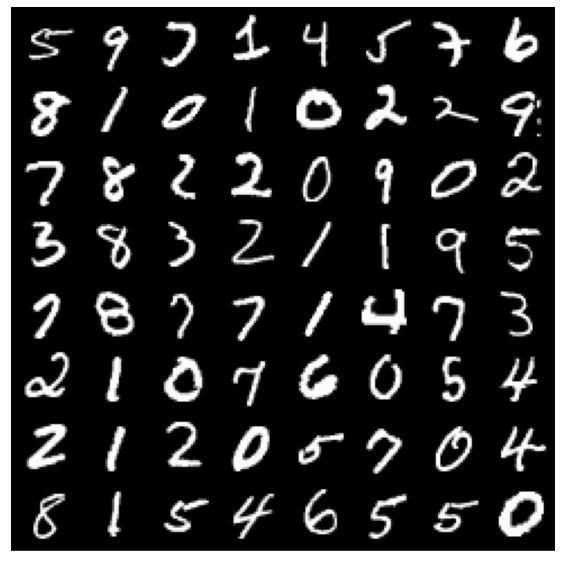

In [11]:
image = next(iter(data_loader))
plt.figure(figsize=(10, 10))
plt.xticks([])
plt.yticks([])
plt.imshow(make_grid(image[:64], nrow=8, normalize=True).permute(1, 2, 0))
plt.show()

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(256, 1, kernel_size=4, stride=2, padding=1, bias=False),

            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

dis = Discriminator().to(device=device)
summary(dis, input_size=(1, 28, 28), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [1400, 64, 14, 14]           1,024
       BatchNorm2d-2         [1400, 64, 14, 14]             128
         LeakyReLU-3         [1400, 64, 14, 14]               0
            Conv2d-4          [1400, 128, 7, 7]         131,072
       BatchNorm2d-5          [1400, 128, 7, 7]             256
         LeakyReLU-6          [1400, 128, 7, 7]               0
            Conv2d-7          [1400, 256, 3, 3]         524,288
       BatchNorm2d-8          [1400, 256, 3, 3]             512
         LeakyReLU-9          [1400, 256, 3, 3]               0
           Conv2d-10            [1400, 1, 1, 1]           4,096
          Flatten-11                  [1400, 1]               0
          Sigmoid-12                  [1400, 1]               0
Total params: 661,376
Trainable params: 661,376
Non-trainable params: 0
-------------------------------

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 256, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 28, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(28),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(28, 1, kernel_size=4, stride=2, padding=3, bias=False),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.model(x)

gen = Generator().to(device=device)
summary(gen, input_size=(latent_size, 1, 1), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1          [1400, 256, 4, 4]         262,144
       BatchNorm2d-2          [1400, 256, 4, 4]             512
              ReLU-3          [1400, 256, 4, 4]               0
   ConvTranspose2d-4           [1400, 64, 8, 8]         262,144
       BatchNorm2d-5           [1400, 64, 8, 8]             128
              ReLU-6           [1400, 64, 8, 8]               0
   ConvTranspose2d-7         [1400, 28, 16, 16]          28,672
       BatchNorm2d-8         [1400, 28, 16, 16]              56
              ReLU-9         [1400, 28, 16, 16]               0
  ConvTranspose2d-10          [1400, 1, 28, 28]             448
             Tanh-11          [1400, 1, 28, 28]               0
Total params: 554,104
Trainable params: 554,104
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.34
Forward/

In [14]:
image_files = []
latent_vec = torch.randn(image_number, latent_size, 1, 1, device=device)
latent_vec.shape

torch.Size([25, 64, 1, 1])

In [15]:
def save_outputs(index):
    fake = gen(latent_vec)
    file_path = f'./genimages/gen-image-{index}.png'
    save_image(fake, file_path, nrow=5, normalize=True)
    image_files.append(imageio.imread(file_path))

save_outputs(0)

In [16]:
def train_discriminator(batch_size, real_images, dis_opt, loss):
    dis_opt.zero_grad()

    # ones and zeros
    ones = torch.ones(batch_size, 1, device=device)
    zeros = torch.zeros(batch_size, 1, device=device)

    # get fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = gen(latent)

    # get the prdictions
    real_preds = dis(real_images)
    fake_preds = dis(fake_images)

    # get the loss
    real_loss = loss(real_preds, ones)
    fake_loss = loss(fake_preds, zeros)

    dis_loss = (real_loss + fake_loss)/2

    ret_loss = dis_loss.item()

    # adjust the weights
    dis_loss.backward()
    dis_opt.step()

    return ret_loss

def train_generator(batch_size, gen_opt, loss):
    # train generator
    gen_opt.zero_grad()

    # ones and zeros
    ones = torch.ones(batch_size, 1, device=device)

    # get generated images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = gen(latent)

    # get the predictions
    fake_preds = dis(fake_images)

    # get the loss
    gen_loss = loss(fake_preds, ones)

    ret_loss = gen_loss.item()

    # adjust the weights
    gen_loss.backward()
    gen_opt.step()

    return ret_loss

In [17]:
def train(epochs=epochs):
    torch.cuda.empty_cache()
    
    loss = nn.BCELoss()
    loss_gen = []
    loss_dis = []

    dis_opt = optim.Adam(dis.parameters(), lr=dis_learning_rate)
    gen_opt = optim.Adam(gen.parameters(), lr=gen_learning_rate)
    width = len(str(epochs))

    train_start = time.time()

    for e in range(1, epochs+1):
        epoch_start = time.time()
        print(f"Epoch[{e:0{width}}/{epochs}] :: ", end="")
        
        for real_images in data_loader:
            real_images = real_images.to(device)

            dis_loss = train_discriminator(batch_size, real_images, dis_opt, loss)
            gen_loss = train_generator(batch_size, gen_opt, loss)

        epoch_end = time.time()
        
        loss_dis.append(dis_loss)
        loss_gen.append(gen_loss)
        
        print(
            f"Discriminator Loss = {loss_dis[-1]:.4f}, Generator Loss = {loss_gen[-1]:.4f}, "
            f"Epoch Time = {epoch_end-epoch_start:.4f}s, Total Time = {epoch_end-train_start:.4f}s"
        )

        save_outputs(e)
    
    train_end = time.time()
    
    print(f"\nTotal Training Time = {train_end-train_start:.4f}s")
    print(f"End Training :: Discriminator Loss = {loss_dis[-1]:.4f}, Generator Loss = {loss_gen[-1]:.4f}")
    
    return loss_dis, loss_gen

In [18]:
losses = train()

Epoch[001/200] :: Discriminator Loss = 0.0073, Generator Loss = 5.8778, Epoch Time = 21.6781s, Total Time = 21.6781s
Epoch[002/200] :: Discriminator Loss = 0.0016, Generator Loss = 6.9658, Epoch Time = 21.6299s, Total Time = 43.3217s
Epoch[003/200] :: Discriminator Loss = 0.0248, Generator Loss = 7.1519, Epoch Time = 21.5066s, Total Time = 64.8416s
Epoch[004/200] :: Discriminator Loss = 0.0077, Generator Loss = 6.6185, Epoch Time = 21.5767s, Total Time = 86.4324s
Epoch[005/200] :: Discriminator Loss = 0.0062, Generator Loss = 7.5962, Epoch Time = 21.6526s, Total Time = 108.0994s
Epoch[006/200] :: Discriminator Loss = 0.0042, Generator Loss = 6.8509, Epoch Time = 21.4975s, Total Time = 129.6102s
Epoch[007/200] :: Discriminator Loss = 0.0028, Generator Loss = 8.2375, Epoch Time = 21.5678s, Total Time = 151.1912s
Epoch[008/200] :: Discriminator Loss = 0.0034, Generator Loss = 8.1534, Epoch Time = 21.7312s, Total Time = 172.9352s
Epoch[009/200] :: Discriminator Loss = 0.0031, Generator Los

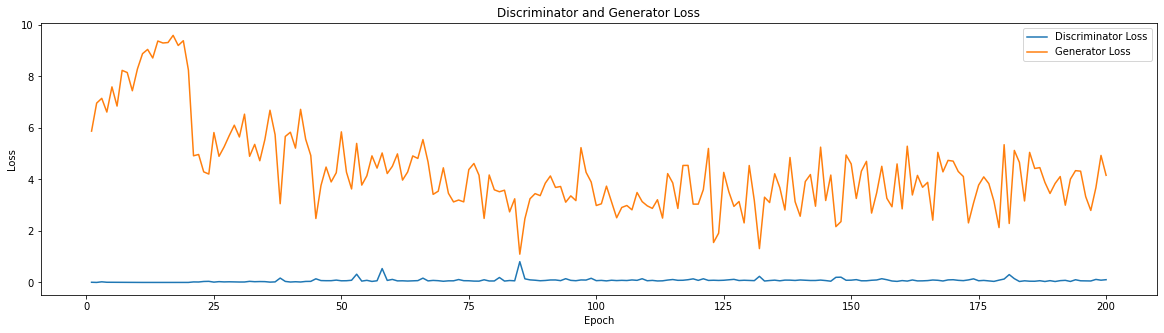

In [19]:
plt.figure(figsize=(20, 5))
plt.plot(range(1, epochs+1), losses[0], label="Discriminator Loss")
plt.plot(range(1, epochs+1), losses[1], label="Generator Loss")
plt.title("Discriminator and Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

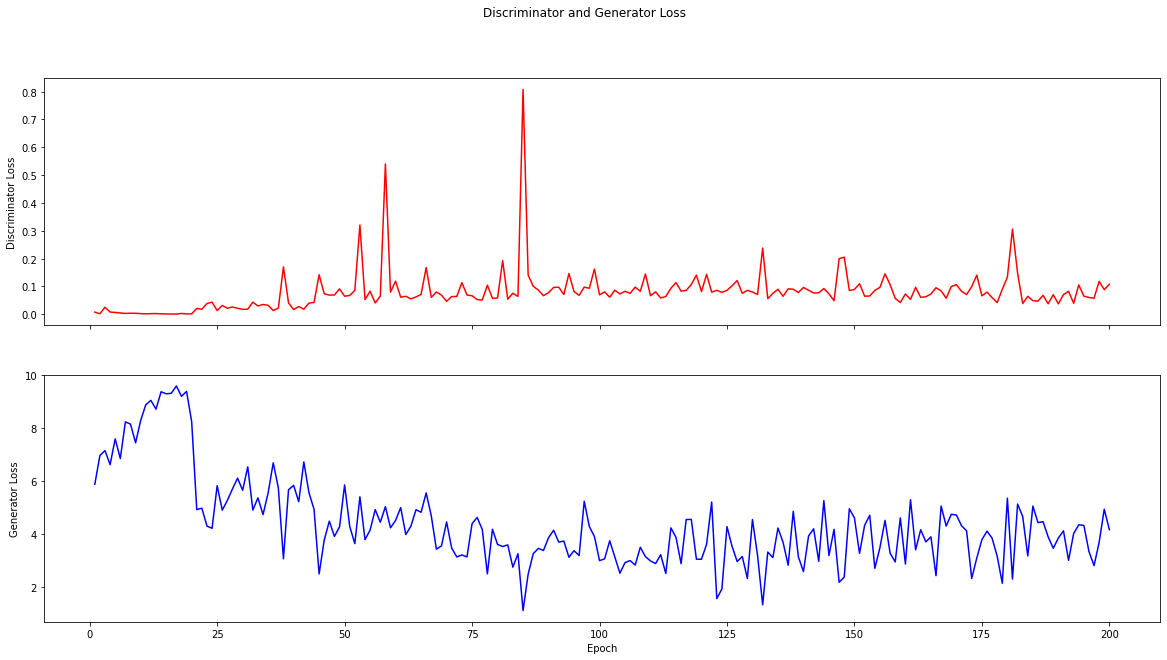

In [20]:
fig, (dis_ax, gen_ax) = plt.subplots(2, 1, sharex=True, figsize=(20,10))

fig.suptitle("Discriminator and Generator Loss")

dis_ax.plot(range(1, epochs+1), losses[0], color='r', label="Discriminator Loss")
dis_ax.set_ylabel("Discriminator Loss")

gen_ax.plot(range(1, epochs+1), losses[1], color='b', label="Generator Loss")
gen_ax.set_ylabel("Generator Loss")
gen_ax.set_xlabel("Epoch")

plt.show()

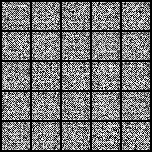

In [21]:
imageio.mimsave('./gen-images.gif', image_files, duration=0.5)
Image(open('./gen-images.gif', 'rb').read(), width=600, height=600)

In [22]:
checkpoint = {
    'discriminator' : {
        'model' : Discriminator(),
        'state_dict' : dis.state_dict()
    },
    'generator' : {
        'model' : Generator(),
        'state_dict' : gen.state_dict()
    }
}
torch.save(checkpoint, 'model_checkpoint.pth')

In [25]:
def load_model(file_path, device='cpu'):
    checkpoint = torch.load(file_path)
    dis = checkpoint['discriminator']['model'].to(device)
    gen = checkpoint['generator']['model'].to(device)
    dis.load_state_dict(checkpoint['discriminator']['state_dict'])
    gen.load_state_dict(checkpoint['generator']['state_dict'])

    return dis, gen
_, gen_net = load_model('model_checkpoint.pth', device)

In [26]:
print(gen_net)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(64, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 28, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(28, 1, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), bias=False)
    (10): Tanh()
  )
)


In [27]:
def show_images():
    with torch.no_grad():
        gen_net.eval()
        latent = torch.randn(image_number, latent_size, 1, 1, device=device)
        gen_images = gen_net(latent)

        plt.figure(figsize=(10, 10))
        plt.xticks([])
        plt.yticks([])
        plt.imshow(make_grid(gen_images.cpu(), nrow=5, normalize=True).permute(1, 2, 0))
        plt.show()

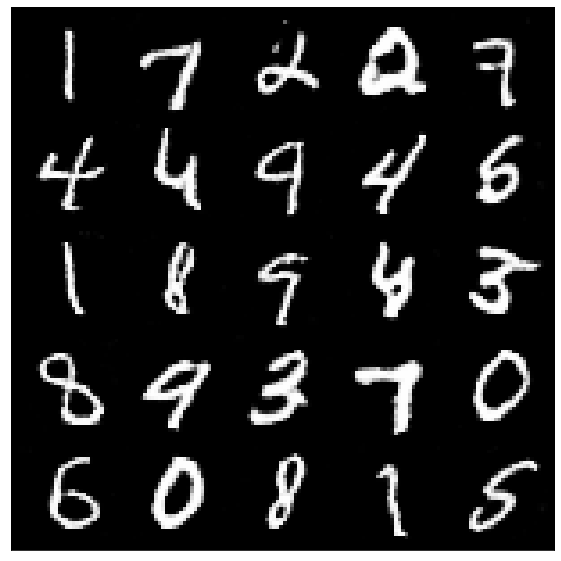

In [28]:
show_images()